In [1]:
import os, sys, warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

sns.set_context(context='poster')

bigsize   = 20
midsize   = 18
smallsize = 14
hugesize  = 24

from matplotlib.path    import Path
from matplotlib.colors  import to_hex
from matplotlib.patches import Polygon, PathPatch, Rectangle

# Download data

### Download from [UCSC Genome Browser](http://genome.ucsc.edu) @ 2020.03.17

Tools (Table Browser) -> hg38 -> Mapping and Sequencing -> Chromosome Band (Ideogram)

or

From UCSC database [Links](http://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/cytoBand.txt.gz)


# Load data

In [2]:
# Load table
ideo = pd.read_csv('cytoBand.txt.gz',sep='\t',names=['chrom','chromStart','chromEnd','name','gieStain']).set_index('chrom')
# Get chromosomes
chrMain = sorted(ideo.index[ideo.index.str.contains(r'^chr\d+$')].unique().tolist(), key=lambda x: int(x.strip('^chr'))) + ['chrX','chrY']
# Clean table
ideo = ideo.loc[chrMain]

In [3]:
# Karyotype colors From [CIRCOS](http://circos.ca)

gpos100 = 0,0,0
gpos    = 0,0,0
gpos75  = 130,130,130
gpos66  = 160,160,160
gpos50  = 200,200,200
gpos33  = 210,210,210
gpos25  = 200,200,200
gvar    = 220,220,220
gneg    = 255,255,255
acen    = 217,47,39
stalk   = 100,127,164

# Map color to name
color_dict = dict( 
    zip(
        ideo['gieStain'].unique(),                # Stain results
        list(                                     # Get hex color
            map(
                to_hex,                           # Convert to hex color
                np.array(
                    list(                         # Get RGB colors ([0,255])
                    map(eval,                     # Convert to RGB colors ([0,255])
                        ideo['gieStain'].unique() # Stain results
                       )
                    )
                )/255                             # Convert to RGB colors ([0,1])
               )
            )
       )
)

# Plot code
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.CURVE4,
    Path.CURVE4,
    Path.CURVE4,
    Path.CLOSEPOLY,
]

# Plot factor
chrom_factor = 2.5e8
round_factor = 0.005
space_factor = 0.5

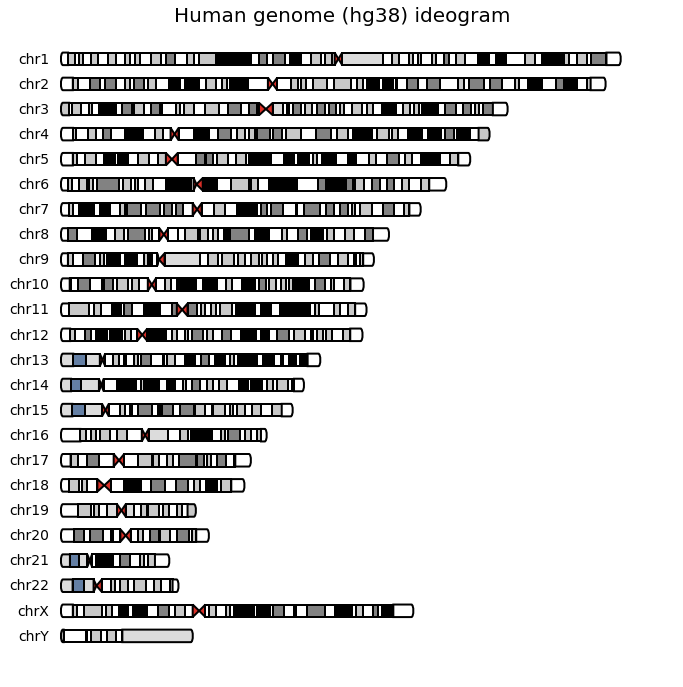

In [4]:
fig, ax = plt.subplots(figsize=(12,12))

for n,chrom in enumerate(chrMain):
    midpoint = n-1+space_factor/2
    tag_acen = 1

    ax.text( -0.025, midpoint, chrom, ha='right',va='center',fontsize=smallsize)

    for idx, row in ideo.loc[chrom].reset_index().iterrows():
        start    = row['chromStart']/chrom_factor
        end      = row['chromEnd']  /chrom_factor
        gieStain = row['gieStain']

        # Start
        if idx == 0:
            v1 = [
                ( end, n-1+space_factor ),
                ( end, n-1 ),
                ( start, n-1 ),
                ( start-round_factor, n-1 ),
                ( start-round_factor, n-1+space_factor),
                ( start, n-1+space_factor ),
                ( end, n-1+space_factor ),
            ]
            p = PathPatch(Path(v1, codes), facecolor = color_dict[gieStain], edgecolor='black', lw=2)
            ax.add_patch(p)
        # End
        elif idx == ideo.loc[chrom].shape[0]-1:
            v2 = [
                ( start, n-1),
                ( start, n-1+space_factor),
                ( end, n-1+space_factor),
                ( end+round_factor, n-1+space_factor),
                ( end+round_factor, n-1),
                ( end, n-1),
                ( start, n-1),
            ]
            p = PathPatch(Path(v2, codes), facecolor = color_dict[gieStain], edgecolor='black', lw=2)
            ax.add_patch(p)
        # Centromere
        elif gieStain == 'acen':
            if tag_acen == 1:
                triangle = [
                    (start,n-1),
                    (start,n-1+space_factor),
                    (end, midpoint)
                ]
                tag_acen = 0
            elif tag_acen == 0:
                triangle = [
                    (end,n-1),
                    (end,n-1+space_factor),
                    (start, midpoint)
                ]
                tag_acen = -1
            else:
                print ('Bug at acen!')
                continue
            p = Polygon(triangle, facecolor = color_dict[gieStain], edgecolor='black', lw=2)
            ax.add_patch(p)
        else:
            p = Rectangle((start,n-1), end-start, height=space_factor, facecolor = color_dict[gieStain], edgecolor='black', lw=2)
            ax.add_patch(p)
#         break
#     break

ax.set_xlim(-0.1,1+0.1)
ax.set_ylim(24,-2)
ax.set_title('Human genome (hg38) ideogram', fontsize=bigsize)
ax.axis('off')

fig.savefig('ideogram_hg38.svg', transparent=True, bbox_inches='tight')
fig.savefig('ideogram_hg38.png', transparent=True, bbox_inches='tight')

plt.show()